In [125]:
import sys
sys.path.append('../src')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 

from GPflow.likelihoods import Gaussian
from GPflow.kernels import RBF, White
from GPflow.mean_functions import Constant
from GPflow.sgpr import SGPR, GPRFITC
from GPflow.svgp import SVGP
from GPflow.gpr import GPR

from scipy.cluster.vq import kmeans2

from get_data import get_regression_data
from dgp import DGP
import time

X, Y, Xs, Ys = get_regression_data('concrete', split=0)
print 'N: {}, D: {}, Ns: {}'.format(X.shape[0], X.shape[1], Xs.shape[0])

def make_dgp(X, Y, Z, L):
    D = X.shape[1]
    Y_mean, Y_std = np.average(Y), np.std(Y) 
    
    # the layer shapes are defined by the kernel dims, so here all hidden layers are D dimensional 
    kernels = []
    for l in range(L):
        kernels.append(RBF(D, lengthscales=1., variance=1.))
        
    # between layer noise (doesn't actually make much difference but we include it anyway)
    for kernel in kernels[:-1]:
        kernel += White(D, variance=1e-5) 
        
    mb = 10000 if X.shape[0] > 10000 else None 
    model = DGP(X, Y, Z, kernels, Gaussian(), num_samples=1, minibatch_size=mb)

    # same final layer inits we used for the single layer model
    model.layers[-1].kern.variance = Y_std**2
    model.likelihood.variance = Y_std*0.1 
    model.layers[-1].mean_function = Constant(Y_mean)
    model.layers[-1].mean_function.fixed = True
    
    # start the inner layers almost deterministically 
    for layer in model.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    
    return model

Z_100 = kmeans2(X, 100, minit='points')[0]
m_dgp2 = make_dgp(X, Y, Z_100, 2)
m_dgp3 = make_dgp(X, Y, Z_100, 3)






N: 927, D: 8, Ns: 103


In [126]:
m_dgp3.optimize(tf.train.AdamOptimizer(0.01), maxiter=2000)


     fun: 5928.3638708662947
     jac: array([-182.75807159,  239.98005756, -371.53566345, ...,   -3.5766934 ,
          2.19323833, -281.83249718])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([-0.32575271,  3.0821096 ,  0.46172013, ..., -0.66667213,
       -0.50068006,  3.40989181])

In [127]:
L1, L2, L3 = m_dgp3.predict_all_layers(Xs, 500)

In [137]:
res = []
d = 7
for i in range(len(Xs)):
    res.append(np.corrcoef(L1[:, i, d], L3[:, i, 0])[0, 1])
ind_max = np.argmax(res)
ind_min = np.argmin(res)
print max(res)
print min(res)
print ind


0.886051232712
-0.224225289106
70


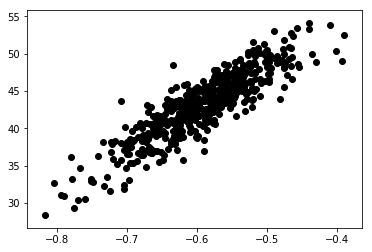

In [138]:
for l1, l3 in zip(L1, L3):
    plt.scatter(l1[ind_max, d], l3[ind_max, 0], color='k')
plt.show()

    